In [1]:
!nvidia-smi

Wed Nov  3 11:18:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
KERAS_MODELS_ABSOLUTE_PATH = '/content/gdrive/My Drive/2ecnn13'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install -qq tensorflow-datasets -U
!tfds --version

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
TensorFlow Datasets: 4.4.0


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
plt.rc('figure', figsize=(13, 4))

2.6.0


In [6]:
if not tf.io.gfile.exists(KERAS_MODELS_ABSOLUTE_PATH):
  print('You should create', KERAS_MODELS_ABSOLUTE_PATH, 'directory manually')
  assert False

In [7]:
train_dataset, test_dataset, valid_dataset = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-musan-1.appspot.com',
    as_supervised=True)
train_dataset.cardinality().numpy()

1825800

In [8]:
train_dataset = train_dataset.map(lambda x, y: (x[1:-1], y)).cache()
test_dataset  = test_dataset.map(lambda x, y:  (x[1:-1], y)).cache()
valid_dataset = valid_dataset.map(lambda x, y: (x[1:-1], y)).cache()

In [9]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [10]:
def streaming_input_output(streaming, t, inputs, otputs, x):
  if streaming:
    otputs.append(x)
    x = keras.Input(shape=[t] + x.shape[2:])
    inputs.append(x)
  return x

In [11]:
def build_model(in_shape, activation, pooling, out_shape, *in_steps):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  inputs, outputs = [], []
  streaming = in_shape[0] == 1

  x = x_in = keras.Input(shape=in_shape)

  for i in in_steps:
    x = keras.layers.Conv1D(i, 1, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.SpatialDropout1D(i / 1280.0)(x)

  for i in range(4):
    x = streaming_input_output(streaming, 1 + 2**i, inputs, outputs, x)
    x = keras.layers.Conv1D(x.shape[-1], 2,
                            dilation_rate=2**i, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.SpatialDropout1D(0.1)(x)

  x = streaming_input_output(streaming, 32, inputs, outputs, x)
  x = pooling(x.shape[1])(x)
  x = keras.layers.Flatten()(x)

  for i in x.shape[-1] * np.array([2, 1]):
    x = keras.layers.Dense(i, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(activation)(x)
    x = keras.layers.Dropout(i / 1280.0)(x)

  x = keras.layers.Dense(out_shape)(x)
  return keras.Model([x_in] + inputs, [x] + outputs, name='second_ensemble')

In [12]:
def build_ensemble(builders=None, models=None, activation=None, streaming=False):
  in_shape = (1 if streaming else 47, 13)
  if models:
    x_in = keras.Input(shape=in_shape)
    x = [keras.Model(m.inputs, m.outputs) for m in models]
    if streaming:
      inputs = [[keras.Input(e.shape[1:]) for e in m.inputs[1:]] for m in x]
      x = [e([x_in] + i) for e, i in zip(x, inputs)]
      inputs = [i for e in inputs for i in e]
      outputs = [i for e in x for i in e[1:]]
      x = [e[0] for e in x]
    else:
      inputs, outputs = [], []
      x = [e(x_in) for e in x]
    if activation:
      x = [keras.layers.Activation(activation)(e) for e in x]
      x = keras.layers.Average()(x)
    else:
      b, c = x
      b = tf.squeeze(b, -1)
      b = tf.greater(b, 2) # threshold
      u = tf.greater(c[:,10], c[:,11])
      u = tf.where(u, 10, 11)
      x = tf.where(b, tf.argmax(c, -1, u.dtype), u)
      x = tf.one_hot(x, 12)
    return keras.Model([x_in] + inputs, [x] + outputs)
  else:
    return tuple(b(in_shape, *a) for b, *a in builders)

In [13]:
models_builders_bin = (
  (build_model, 'leaky_relu', keras.layers.MaxPool1D, 1,     128),
  (build_model, 'relu',       keras.layers.AvgPool1D, 1,     128),
  (build_model, 'relu6',      keras.layers.MaxPool1D, 1, 64, 128),
  (build_model, 'elu',        keras.layers.AvgPool1D, 1, 64, 128),
)
models_bin = build_ensemble(builders=models_builders_bin)

In [14]:
def train_model(model, loss, train_dataset, valid_dataset):

  model.compile(
    loss=loss(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

  early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

  train_batch = train_dataset.shuffle(train_dataset.cardinality())
  train_batch = train_batch.batch(128)
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 1, 3, 5), y))
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))
  train_batch = train_batch.prefetch(tf.data.AUTOTUNE)

  valid_batch = valid_dataset.batch(128)
  valid_batch = valid_batch.prefetch(tf.data.AUTOTUNE)

  # plt.imshow(list(train_batch.take(1))[0][0][0].numpy().T)
  # plt.show()

  history = model.fit(train_batch,
                      validation_data=valid_batch,
                      callbacks=[early_stopping],
                      verbose=2,
                      epochs=1000) # play with google colab time limit

  model.set_weights(early_stopping.best_weights)
  return history

In [15]:
def train_ensemble(ensemble_models, loss, train_dataset, valid_dataset):

  for model in ensemble_models:
    md5 = str(model.get_config())
    md5 = !echo "$md5" | md5sum
    md5 = md5[0].split()[0]
    weights_file = "%s/%s.h5" % (KERAS_MODELS_ABSOLUTE_PATH, md5)

    if tf.io.gfile.exists(weights_file):
      print('Restoring model weights from', md5)
      model.load_weights(weights_file)
    else:
      history = train_model(model, loss, train_dataset, valid_dataset)
      model.save_weights(weights_file)
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Valid'], loc='upper right')
      plt.show() 

In [16]:
train_ensemble(models_bin, keras.losses.BinaryCrossentropy,
               train_dataset, valid_dataset)

Restoring model weights from 28323f803767caeb2261fa7304685acc
Restoring model weights from 3a120eaa0ec426481f89827dfc4a2782
Restoring model weights from f6540761d812702d3bb4466310e20b93
Restoring model weights from 4b4319045000911ff374050fa7882570


In [17]:
bin_ens = build_ensemble(models=models_bin, activation='linear')

In [18]:
def evaluate_ensemble(models, test_dataset, valid_dataset):
  history = []
  for model in models:
    o = model.output_shape[-1]   
    d = lambda x: np.argmax(x, -1) if o > 1 else x.squeeze(-1) > 0
    pred = d(model.predict(test_dataset.batch(512)))
    history.append(np.sum(pred != list(test_dataset.map(lambda x, y: y))))
    pred = d(model.predict(valid_dataset.batch(512)))
    history.append(np.sum(pred != list(valid_dataset.map(lambda x, y: y))))
  plt.xlim(-0.6, len(history)/2 - 0.4)
  plt.bar(np.arange(len(history)/2) - 0.2, history[::2], 0.4)
  plt.bar(np.arange(len(history)/2) + 0.2, history[1::2], 0.4)
  return np.array(history).reshape(-1, 2).tolist()

[[15, 12], [17, 10], [17, 10], [14, 7], [11, 9]]

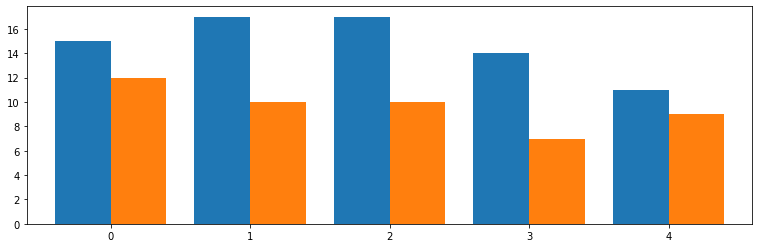

In [19]:
evaluate_ensemble(models_bin + (bin_ens,), test_dataset, valid_dataset)

In [20]:
train_dataset, test_dataset, valid_dataset = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-gsc-1.appspot.com',
    as_supervised=True)
train_dataset.cardinality().numpy()

1095480

In [21]:
train_dataset = train_dataset.map(lambda x, y: (x[1:-1], y)).cache()
test_dataset  = test_dataset.map(lambda x, y:  (x[1:-1], y)).cache()
valid_dataset = valid_dataset.map(lambda x, y: (x[1:-1], y)).cache()

[[312, 303], [299, 287], [316, 295], [315, 298], [309, 293]]

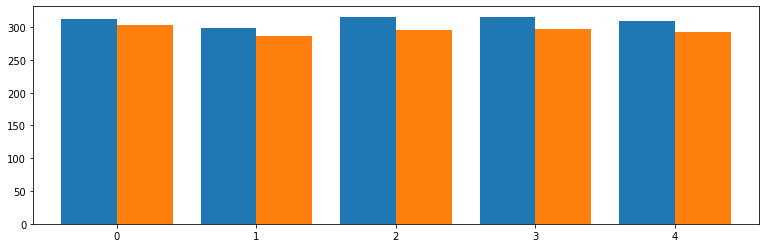

In [22]:
evaluate_ensemble(models_bin + (bin_ens,),
                  test_dataset.map(lambda x, y: [x, y < 10]),
                  valid_dataset.map(lambda x, y: [x, y < 10]))

In [23]:
models_builders_cat = (
  (build_model, 'leaky_relu', keras.layers.MaxPool1D, 12,     128),
  (build_model, 'relu',       keras.layers.AvgPool1D, 12,     128),
  (build_model, 'relu6',      keras.layers.MaxPool1D, 12, 64, 128),
  (build_model, 'elu',        keras.layers.AvgPool1D, 12, 64, 128),
)
models_cat = build_ensemble(builders=models_builders_cat)

In [24]:
train_ensemble(models_cat, keras.losses.SparseCategoricalCrossentropy,
               train_dataset, valid_dataset)

Restoring model weights from e7e8bec4019f75b50021d0976ccd6c38
Restoring model weights from 77ea91aa526708b463ab0a466befa487
Restoring model weights from b86d75d1480db917ab133cc6027564c0
Restoring model weights from 76ae1b4ae2ff082f3154066d5e36578e


In [25]:
cat_ens = build_ensemble(models=models_cat, activation='softmax')

In [26]:
ens = build_ensemble(models=[bin_ens, cat_ens])
ens.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 47, 13)]     0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 12)           830896      input_3[0][0]                    
__________________________________________________________________________________________________
model_5 (Functional)            (None, 1)            825220      input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None,)              0           model_6[0][0]                    
____________________________________________________________________________________________

[[45, 27], [48, 27], [51, 23], [42, 30], [40, 27], [59, 33]]

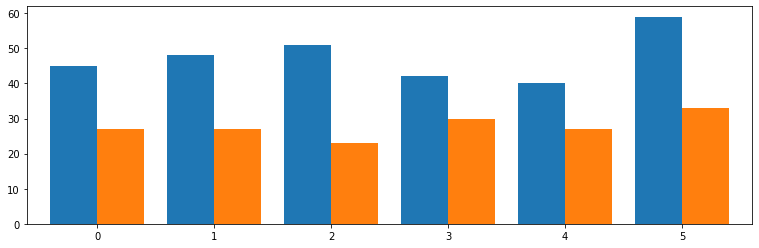

In [27]:
evaluate_ensemble(models_cat + (cat_ens, ens,),
                  test_dataset, valid_dataset)

In [28]:
matrix = tf.math.confusion_matrix(
  list(test_dataset.map(lambda x, y: y)),
  ens.predict(test_dataset.batch(4096)).argmax(axis=-1)).numpy()
for r in matrix:
  l = np.sum(r)
  for i in r:
    print(('%.2f' % (i / l)).replace('0.00', ' .  '), end = ' ')
  print("|", l)

0.99  .    .    .    .    .    .   0.01  .    .    .    .   | 315
 .   0.97  .    .    .    .    .    .    .   0.01 0.01  .   | 309
 .    .   0.99  .    .    .    .    .    .    .   0.01  .   | 304
 .    .    .   0.97  .    .    .    .    .    .   0.03  .   | 304
 .    .    .    .   0.99  .    .    .    .    .   0.01  .   | 310
 .    .    .    .    .   0.97  .    .    .    .   0.02  .   | 336
 .    .    .    .    .    .   1.00  .    .    .    .    .   | 249
 .    .    .    .    .    .    .   1.00  .    .    .    .   | 306
 .    .    .    .    .    .    .    .   1.00  .    .    .   | 298
 .    .    .    .    .   0.01  .    .    .   0.98 0.01  .   | 312
 .   0.01  .   0.01 0.01  .    .    .    .    .   0.97  .   | 365
 .    .    .    .    .    .    .    .    .    .    .   1.00 | 365


In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(ens)
tflite_model = converter.convert()
with open("_2ecnn47.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmptnkb9rqi/assets


INFO:tensorflow:Assets written to: /tmp/tmptnkb9rqi/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [30]:
!md5sum '_2ecnn47.tflite'
!mv '_2ecnn47.tflite' "$KERAS_MODELS_ABSOLUTE_PATH"

f85c06ab82059f35b7b622c42a690247  _2ecnn47.tflite


In [31]:
def transfer_weights(dest, src):
  for dest, src in zip(dest, src):
    for layer in dest.layers:
      if layer.get_weights():
        print("Transfer weights for layer {}".format(layer.name))
        layer.set_weights(src.get_layer(name=layer.name).get_weights())

In [32]:
models_bin_str = build_ensemble(builders=models_builders_bin, streaming=True)
transfer_weights(models_bin_str, models_bin)

Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer dense_1
Transfer weights for layer batch_normalization_6
Transfer weights for layer conv1d
Transfer weights for layer conv1d_1
Transfer weights for layer conv1d_2
Transfer weights for layer conv1d_3
Transfer weights for layer conv1d_4
Transfer weights for layer batch_normalization
Transfer weights for layer batch_normalization_1
Transfer weights for layer batch_normalization_2
Transfer weights for layer batch_normalization_3
Transfer weights for layer batch_normalization_4
Transfer weights for layer dense_2
Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer dense_1
Transfer weights for layer batch_normalization_6
Transfer weights for layer conv1d
Transfer weights for layer conv1d_1
Transfer weights for layer conv1d_2
Transfer weights for layer conv1d_3
Transfer weights for layer conv1d_4
Transfer weights for layer batch_n

In [33]:
models_cat_str = build_ensemble(builders=models_builders_cat, streaming=True)
transfer_weights(models_cat_str, models_cat)

Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer dense_1
Transfer weights for layer batch_normalization_6
Transfer weights for layer conv1d
Transfer weights for layer conv1d_1
Transfer weights for layer conv1d_2
Transfer weights for layer conv1d_3
Transfer weights for layer conv1d_4
Transfer weights for layer batch_normalization
Transfer weights for layer batch_normalization_1
Transfer weights for layer batch_normalization_2
Transfer weights for layer batch_normalization_3
Transfer weights for layer batch_normalization_4
Transfer weights for layer dense_2
Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer dense_1
Transfer weights for layer batch_normalization_6
Transfer weights for layer conv1d
Transfer weights for layer conv1d_1
Transfer weights for layer conv1d_2
Transfer weights for layer conv1d_3
Transfer weights for layer conv1d_4
Transfer weights for layer batch_n

In [34]:
bin_str_ens = build_ensemble(models=models_bin_str, activation='linear', streaming=True)
cat_str_ens = build_ensemble(models=models_cat_str, activation='softmax', streaming=True)
ens_str = build_ensemble(models=[bin_str_ens, cat_str_ens], streaming=True)
ens_str.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 1, 13)]      0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
input_71 (InputLayer)           [(None, 3, 128)]     0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           [(None, 5, 128)]     0                                            
___________________________________________________________________________________________

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(ens_str)
tflite_model = converter.convert()
with open("2ecnn13.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp836r2rvf/assets


INFO:tensorflow:Assets written to: /tmp/tmp836r2rvf/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [36]:
!md5sum '2ecnn13.tflite'
!mv '2ecnn13.tflite' "$KERAS_MODELS_ABSOLUTE_PATH"

a0f735910f0c4e7b6f9e995cbd806824  2ecnn13.tflite
